In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from nflows.flows import Flow
from nflows.transforms import MaskedAffineAutoregressiveTransform
from nflows.distributions import StandardNormal
torch.autograd.set_detect_anomaly(True)
from nflows.transforms import CompositeTransform, Sigmoid, AffineTransform

b_low = torch.tensor([0., 0.])
b_high = torch.tensor([10., 10.])

flow_b = Flow(
    CompositeTransform([
        MaskedAffineAutoregressiveTransform(features=2, hidden_features=32),
        Sigmoid(),
        AffineTransform(shift=b_low, scale=b_high - b_low)
    ]),
    StandardNormal([2])
)


In [2]:
flow_b.sample(1)

InputOutsideDomain: 

In [ ]:

# -----------------------
# 1. Generate synthetic data
# -----------------------
N = 30
x = torch.linspace(-3, 3, N).unsqueeze(1)
noise = 0.3 * torch.randn_like(x)
y = 2 * x + 1 + noise  # true relation y = 2x + 1
a_space = torch.linspace(-1, 5, N).unsqueeze(1)
b_space = torch.linspace(-2, 4, N).unsqueeze(1)
combine = torch.stack([a_space, b_space], dim=1)

a_low, a_high = a_space.min().item() - 1, a_space.max().item() + 1
b_low, b_high = b_space.min().item() - 1, b_space.max().item() + 1

flow_a = Flow(
    CompositeTransform([
        MaskedAffineAutoregressiveTransform(features=1, hidden_features=32),
        Sigmoid(),
        AffineTransform(shift=torch.tensor([a_low]), scale=torch.tensor([a_high - a_low]))
    ]),
    StandardNormal([1])
)
flow_b = Flow(
    CompositeTransform([
        MaskedAffineAutoregressiveTransform(features=1, hidden_features=32),
        Sigmoid(),
        AffineTransform(shift=torch.tensor([b_low]), scale=torch.tensor([b_high - b_low]))
    ]),
    StandardNormal([1])
)


In [2]:
flow_a.sample(1)

tensor([[-3.2942]], grad_fn=<DivBackward0>)

In [ ]:

optimizer = torch.optim.Adam(list(flow_a.parameters()) + list(flow_b.parameters()), lr=1e-3)

criterion = nn.MSELoss()
# -----------------------
# 3. Train the flow
# -----------------------
def linear(x, a, b):
    return a*x+b

for step in range(1000):
    optimizer.zero_grad()


    aaa
    log_p_a = flow_a.log_prob(a_space)#+1e-4#*a_space#.mean()
    log_p_b = flow_b.log_prob(b_space)#+1e-4#*b_space
    # with torch.no_grad():
    p_a = torch.exp(log_p_a)
    p_a = p_a / p_a.sum()
    p_b = torch.exp(log_p_b)
    p_b = p_b / p_b.sum()
    a = (p_a * a_space.squeeze()).sum()
    b = (p_b * b_space.squeeze()).sum()

    loss = criterion(y, linear(x, a, b))
    # aaa
    loss.backward()
    optimizer.step()
    if step % 100 == 0:
        with torch.no_grad():
            print(f"epoch: {step}")
            print(f"a = {a.detach().cpu()}", f"b = {b.detach().cpu()}")
            print(f"Step {step}: loss = {loss.item():.3f}")
            print("\n")





Text(0, 0.5, 'Density')

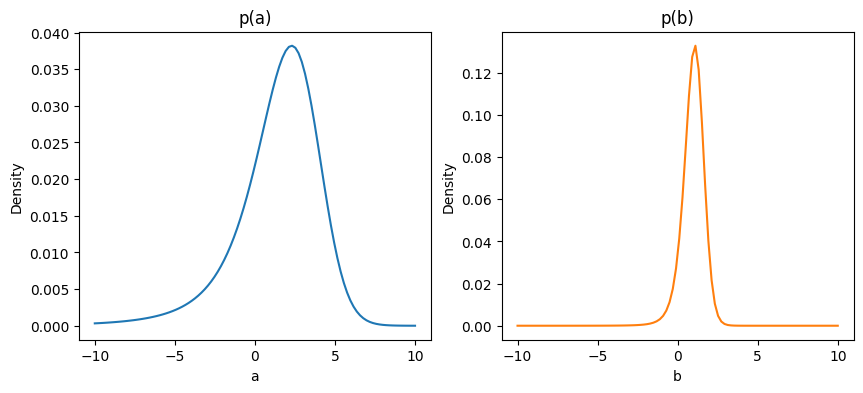

In [124]:
# Evaluate log-probs

new_a_space = torch.linspace(-10, 10, 100).unsqueeze(1)
new_b_space = torch.linspace(-10, 10, 100).unsqueeze(1)

log_p_a = flow_a.log_prob(new_a_space)
log_p_b = flow_b.log_prob(new_b_space)

# Convert to probabilities (densities)
p_a = torch.exp(log_p_a)
p_b = torch.exp(log_p_b)

# Normalize for nicer plotting
p_a = p_a / p_a.sum()
p_b = p_b / p_b.sum()

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))


new_a_space = torch.linspace(-10, 10, 100)
 
axes[0].plot(new_a_space.detach().cpu(), p_a.detach().cpu(), color="tab:blue")
axes[0].set_title("p(a)")
axes[0].set_xlabel("a")
axes[0].set_ylabel("Density")

axes[1].plot(new_b_space.detach().cpu(), p_b.detach().cpu(), color="tab:orange")
axes[1].set_title("p(b)")
axes[1].set_xlabel("b")
axes[1].set_ylabel("Density")